Mapping from David's labels to ours

Modelling = in silico
Other = others (but maybe one is a superset of the other given the additional categories, especially experimental (in vivo/vitro))
Meta analysis = meta_study + RCT_review
Randomized controlled trial = RCT
Non-randomized trial = controlled_trial_non_randomised
Prospective observationion + Retrospective cohort + Time-series analysis + Case-control + Cross-sectional + Case Study = comparative_study + descriptive_study = observational study
No map = in_vitro
No map = in_vivo

['Other',
 'Meta analysis',
 'Randomized control trial',
 'Non-randomized trial',
 'Prospective cohort',
 'Time-series analysis',
 'Retrospective cohort',
 'Cross-sectional',
 'Case control',
 'Case study',
 'Simulation']

In [1]:
from common.logging import create_logger
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
from datasets import single_label_multiclass_annotated_study_design, enrich_annotations, annotations_with_specter_embeddings, coronawhy_annotated_study_design
from classifier import train_validate_catboost_model
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def is_labelling_correct(actual_label, predicted_label):
    """
    predicted_label: label trained on David's annotations
    actual_label: ground truth label from our annotations
    """
    if actual_label in [1, 2] and predicted_label == 0:  #actual_label_str in ['in_vitro', 'in_vivo'] predicted_label=='others'
        return True
    if actual_label in [3, 8 ] and predicted_label == 1: #actual_label in [meta_study , RCT_review] predicted_label='systematic review'
        return True
    if actual_label ==4 and predicted_label in [1,2]: #actual label = rct, predicted label = rct/RCT_review
        return True
    if actual_label == 5 and predicted_label==3: #non randomised trials
        return True
    if actual_label in [6, 7] and predicted_label in [4,5,6,7,8]: #david: Prospective observationion + Retrospective cohort + Time-series analysis + Case-control + Cross-sectional + Case Study = ours: comparative_study + descriptive_study = observational stud
        return True
    return False

In [3]:
data_dir = Path('/media/wwymak/Storage/coronawhy/nlp_datasets')
annotations_filepath =Path(data_dir/'Study_Design_Annotation_Snapshot_4_12_20.csv')
metadata_filepath   = data_dir/'metadata.csv.zip'

annotations_coronawhy = coronawhy_annotated_study_design(annotations_filepath, metadata_filepath)
annotations_coronawhy.head()

,cord_uid,title,abstract,label,label_string
0,mmykzj9w,Biological effects of HBV X protein on hepatoc...,The X protein (HBx) of Human hepatitis B virus...,9,others
1,480bzpi1,Do we have enough evidence how seasonal influe...,Abstract Purpose To identify if there is enoug...,8,meta_study
2,n5o7u56f,Bioactive principles from Cordyceps sinensis: ...,Abstract Cordyceps sinensis (CS) is a well-kno...,9,others
3,8rl4kswe,Virus Entry: Open Sesame,Detailed information about the replication cyc...,9,others
4,whfyczcj,Hijacking of the Ubiquitin/Proteasome Pathway ...,The ubiquitin-proteasome system (UPS) ensures ...,9,others


In [5]:
colname_to_number_mapping = {
        k: idx for idx, k in enumerate(['in_silico', 'in_vitro',
                           'in_vivo', 'RCT_review', 'RCT', 'controlled_trial_non_randomised',
                           'comparative_study', 'descriptive_study', 'meta_study'])
    }
colname_to_number_mapping

{'in_silico': 0,
 'in_vitro': 1,
 'in_vivo': 2,
 'RCT_review': 3,
 'RCT': 4,
 'controlled_trial_non_randomised': 5,
 'comparative_study': 6,
 'descriptive_study': 7,
 'meta_study': 8}

In [ ]:
# # key = our name, value = david's label
# coronawhy_to_david_mapping = {
#     'in_silico': 9,
#     'in_vitro':0,
#  'in_vivo':0,
#  'RCT_review': 3,
#  'RCT': 2,
#  'controlled_trial_non_randomised': 3,
#  'comparative_study': 6,
#  'descriptive_study': 7,
#  'meta_study': 1
# }

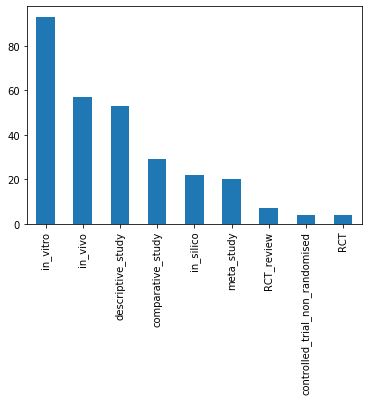

In [5]:
annotations_coronawhy.label_string.value_counts().plot.bar()

In [6]:
# load trained catboost model
cb_model = CatBoostClassifier().load_model(str(data_dir/'catboost_david_annotation_2_may'))

In [8]:
test_pool =  Pool(
            annotations_coronawhy[['title', 'abstract']],
            feature_names=['title', 'abstract'],
            text_features=['title', 'abstract'])
predictions = cb_model.predict(test_pool)
probabilities = cb_model.predict_proba(test_pool)

In [10]:
# david's mappings
label_number_to_study_name_mapping = {
        1: "Systematic review",
        2: "Randomized control trial",
        3: "Non-randomized trial",
        4: "Prospective observational",
        5: "Time-to-event analysis",
        6: "Retrospective observational",
        7: "Cross-sectional",
        8: "Case series",
        9: "Modeling",
        0: "Other"
    } 

In [9]:


predictions_numeric = pd.Series(predictions.squeeze())
predictions_str = pd.Series(predictions.squeeze()).apply(label_number_to_study_name_mapping.get)
predictions_proba = pd.DataFrame(np.max(probabilities, axis=1))

In [33]:
predictions

0                         Other
1                         Other
2                         Other
3                      Modeling
4                         Other
                 ...           
284                       Other
285                 Case series
286                 Case series
287    Randomized control trial
288                 Case series
Length: 289, dtype: object

In [10]:
annotations_coronawhy['catboost_predictions'] = predictions_numeric
annotations_coronawhy['catboost_predictions_str'] = predictions_str
annotations_coronawhy['catboost_predictions_proba'] = predictions_proba
annotations_coronawhy['is_prediction_correct'] = \
    annotations_coronawhy[['catboost_predictions', 'label']] \
    .apply(lambda row: is_labelling_correct(row['label'], row['catboost_predictions']) , axis=1)
annotations_coronawhy.to_csv(data_dir/'catboost_predictions.csv', index=False)

In [11]:
annotations_coronawhy.is_prediction_correct.value_counts()

True     165
False    124
Name: is_prediction_correct, dtype: int64

In [12]:
165/289

0.5709342560553633

In [38]:
lr_model = joblib.load( data_dir/'logistic_specter_embedddings_2may.pkl', compress=3)
lr_predictions = lr_model.predict()

SyntaxError: invalid syntax (<ipython-input-38-f12113916136>, line 1)

In [4]:
metadata = pd.read_csv(metadata_filepath)
test_cord_uids=pd.read_csv('/home/wwymak/Downloads/cord_uid_used.csv')
test_df = test_cord_uids.merge(metadata, left_on='cord_uid', right_on='cord_uid')[['cord_uid', 'title', 'abstract']].fillna('')
test_pool =  Pool(
            test_df[['title', 'abstract']],
            feature_names=['title', 'abstract'],
            text_features=['title', 'abstract'])
predictions = cb_model.predict(test_pool)
probabilities = cb_model.predict_proba(test_pool)

NameError: name 'cb_model' is not defined

In [26]:
test_df['prediction'] = predictions
test_df['prediction'] = test_df['prediction'].apply(label_number_to_study_name_mapping.get)
test_df['prediction_proba'] = pd.Series(np.max(probabilities, axis=1))


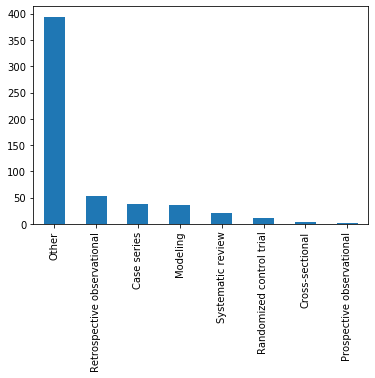

In [27]:
test_df.prediction.value_counts().plot.bar()

In [28]:
test_df[test_df.prediction =='Systematic review'].title.to_list()

['Traditional Chinese herbal medicine for treating novel coronavirus (COVID-19) pneumonia: protocol for a systematic review and meta-analysis',
 'Incidence, clinical characteristics and prognostic factor of patients with COVID-19: a systematic review and meta-analysis',
 'A brief review of antiviral drugs evaluated in registered clinical trials for COVID-19',
 'Role of Chloroquine and Hydroxychloroquine in the Treatment of COVID-19 Infection- A Systematic Literature Review',
 'Risk factors for severe corona virus disease 2019 (COVID-19) patients : a systematic review and meta analysis',
 'Interleukin-6 in COVID-19: A Systematic Review and Meta-Analysis',
 'COVID-19 infection during pregnancy: a systematic review to summarize possible symptoms, treatments, and pregnancy outcomes',
 'Case fatality rate in COVID-19: a systematic review and meta-analysis',
 'Therapeutic Management of COVID-19 Patients: A systematic review',
 'Chloroquine and hydroxychloroquine for the treatment of COVID-19

In [21]:
test_df[test_df.prediction =='Retrospective observational'].title.to_list()

['Analysis of factors associated with disease outcomes in hospitalized patients with 2019 novel coronavirus disease',
 'ACP risk grade: a simple mortality index for patients with confirmed or suspected severe acute respiratory syndrome coronavirus 2 disease (COVID-19) during the early stage of outbreak in Wuhan, China',
 'Clinical Characteristics of 24 Asymptomatic Infections with COVID-19 Screened among Close Contacts in Nanjing, China',
 'Clinical characteristics of 36 non-survivors with COVID-19 in Wuhan, China',
 'Risk factors related to hepatic injury in patients with corona virus disease 2019',
 'Clinical findings in critical ill patients infected with SARS-Cov-2 in Guangdong Province, China: a multi-center, retrospective, observational study',
 'Clinical Features of Patients Infected with the 2019 Novel Coronavirus (COVID-19) in Shanghai, China',
 'Clinical characteristics of 101 non-surviving hospitalized patients with COVID-19: A single center, retrospective study',
 'Early, l

In [29]:
test_df.to_csv('~/Downloads/claims_study_type_classified.csv', index=False)

In [19]:
test_df.prediction.unique()

array(['Other', 'Retrospective observational', 'Case series', 'Modeling',
       'Systematic review', 'Randomized control trial', 'Cross-sectional',
       'Prospective observational'], dtype=object)

In [15]:
metadata[metadata.pmcid.notnull()].pmcid.head(5).to_list()

['PMC125340', 'PMC125375', 'PMC125543', 'PMC126080', 'PMC136939']

In [30]:
metadata[metadata.pmcid.notnull()].pmcid.head(2000).to_csv('~/Downloads/metadata_subset.txt', index=False, header=None)

In [ ]:
Systematic review or meta-analysis of RCTs	(1)
Randomized controlled trial (2)
Non-randomized controlled trial (3)
Comparative study with concurrent controls (cohort studies, case-control studies, or interrupted time series with a control group)	4
Comparative study with a historical control (2 or more single-arm studies, or interrupted time series without a parallel control group)	6
Descriptive study (case series, case reports)	(8)
Systematic review or meta-analysis of studies other than RCTs	1
Other (commentary, editorial, non-systematic review, expert opinion) 0


In [5]:
metadata.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url'],
      dtype='object')

In [6]:
metadata.shape, metadata.pubmed_id.notnull().sum()

((57366, 18), 40905)